In [1]:
import os, argparse, pickle, librosa, joblib
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from scipy.io.wavfile import write
from scipy.io import savemat
import matplotlib.pyplot as plt
import torch
from glob import glob
from eval_utils import *
from utils import *
from utils import snd_denormalizer, acc_normalizer
import models
import IPython.display as ipd
from tqdm import tqdm
from params import get_arg

/root/anaconda3/envs/1.7/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
config = get_arg(['--len', '200', '--latency', '24', '--b', '200', '--loss_weight', '1', '--loss', 'l1','--model','CombineAutoencoder', '--name', 'CombineAutoencoder_b200_d200_lat24_adam_0.002_decay0.7071_featurewav_l1_future_nodiff_weight0.1_subtract'])

SR = 8192
WINDOW_SIZE = 500 # us
data_length = config.len
BATCH_SIZE = config.batch
K, m = 8, 8
ls = 128

In [3]:
ABSpath = '/root'
path = os.path.join(ABSpath, 'ai_model/pytorch/test_model')
data_path = os.path.join(ABSpath,'ai_model/pytorch/test_model')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
accel_raw_data = joblib.load(open(os.path.join(data_path,'stationary_accel_train.joblib'),'rb'))
sound_raw_data = joblib.load(open(os.path.join(data_path,'stationary_sound_train.joblib'),'rb'))
transfer_f = np.array(pickle.load(open(os.path.join(data_path,'transfer_f.pickle'),'rb')))
transfer_f = torch.tensor(transfer_f[::-1,:,:].copy(),device=device)
transfer_f.requires_grad = False

In [4]:
dataset = testDataset(accel_raw_data, sound_raw_data, config)
# dataset = makeDataset(accel_raw_data, sound_raw_data, config, train=False)
if config.norm:
    snd_denorm = snd_denormalizer(config)
    acc_norm = acc_normalizer(config)
if config.name == '':
    name = f'{config.model}'
    name += f'_b{config.b}_d{data_length}' if config.feature == 'wav' else ''
    name += f'_lat{config.latency}_{config.opt}_{config.lr}_decay{config.decay:0.4}'
    name += f'_feature{config.feature}_{config.loss}'
    if config.feature == 'mel':
        name += f'_nfft{config.nfft}'
    if config.relu:
        name += '_relu'
    if config.future:
        name += '_future'
    if config.diff:
        name += f'_{config.diff}'
        name += f'_weight{config.loss_weight}'
    if config.subtract:
        name += f'_subtract'
    if config.norm:
        name += '_norm'
else:
    name = config.name
print(name)
modelsavepath = sorted(glob(os.path.join(path, 'model_save/'+name + '/*')), key=lambda x: float(os.path.basename(x).split('.pt')[0].split('_')[-1]))[1]
if config.feature == 'wav':
    model = getattr(models, config.model)(dataset[0][0].shape[1:], dataset[0][1].shape[1:], dataset[0][0].shape[0], dataset[0][1].shape[0], config).to(device)
elif config.feature == 'mel':
    model = getattr(models, config.model)((config.nmels, 12), (config.len,), (config.len + config.b) // (config.nfft // 2) + 1, 8, config).to(device)

CombineAutoencoder_b200_d200_lat24_adam_0.002_decay0.7071_featurewav_l1_future_nodiff_weight0.1_subtract


In [5]:
print(modelsavepath)
model.load_state_dict(torch.load(modelsavepath)['model'])
dataset_generator = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

/root/ai_model/pytorch/test_model/model_save/CombineAutoencoder_b200_d200_lat24_adam_0.002_decay0.7071_featurewav_l1_future_nodiff_weight0.1_subtract/7_0.0_0.9842.pt


In [6]:
config.range = '90~100'
config.filter = True
filt = bandPassFilter(config)


data_res, sound_res = [], []
y = []
x = []
model.eval()
with torch.no_grad():
    for data, sound in tqdm(dataset_generator):
#         if config.filter:
#             sound = filt(sound.to(device)).cpu()
        sound_res.append(sound)
        
        data = data.to(device)
        if config.norm:
            data = acc_norm(data)
        if config.filter:
            data = filt(data)
            x.append(data.clone().cpu())
            
        if config.feature == 'stft':
            data = list(map(stft, data))
            data = torch.stack(data)
            data = torch.cat([data.real, data.imag], 1)
            
        res = model(data)
        
        if config.feature == 'stft':
            y = torch.stack([res[:,:res.shape[1]//2],res[:,res.shape[1]//2:]],-1)
            
            y = list(map(istft, y))
            res = torch.stack(y,0).transpose(2,1)
            
#         data_res.append(conv_with_S(model(data.to(device)), S_data=transfer_f, device=device, config=config).cpu()[:,0,:])
        res = conv_with_S(res, S_data=transfer_f, device=device, config=config)
        if config.norm:
            res = snd_denorm(res)
        data_res.append(res.cpu())
#         data_res.append(dataset.split(res, config.len // 2 - (config.split_number // 2), config.len // 2 + (config.split_number // 2)))

100%|██████████| 3124/3124 [03:53<00:00, 13.36it/s]


In [7]:

data_res = torch.cat(data_res)
sound_res = torch.cat(sound_res)
data_res = torch.reshape(data_res, (-1,data_res.size(-1)))
sound_res = torch.reshape(sound_res, (-1,data_res.size(-1)))

In [8]:
data_res = - data_res

<Figure size 432x288 with 0 Axes>

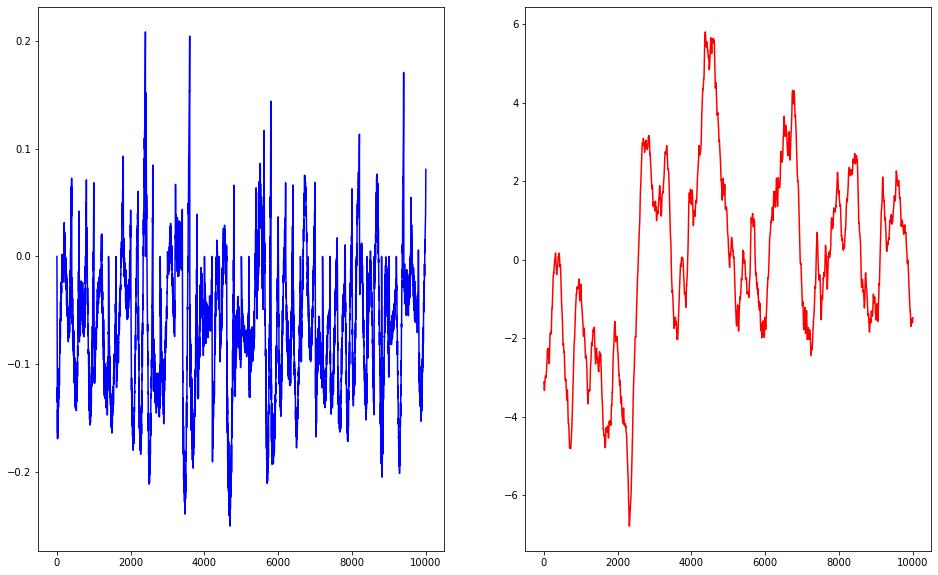

In [9]:

fig = plt.figure()
fig, ax_lst = plt.subplots(1, 2, figsize=(16,10))
ax_lst[0].plot(data_res[:10000,0], color="blue")
ax_lst[1].plot(sound_res[:10000,0], color="red")
# ax_lst[1].plot(np.arange(data_res.size(0)), data_res[:,1])
# ax_lst[0].plot(np.arange(sound_res.size(0)), data_res[:,1])

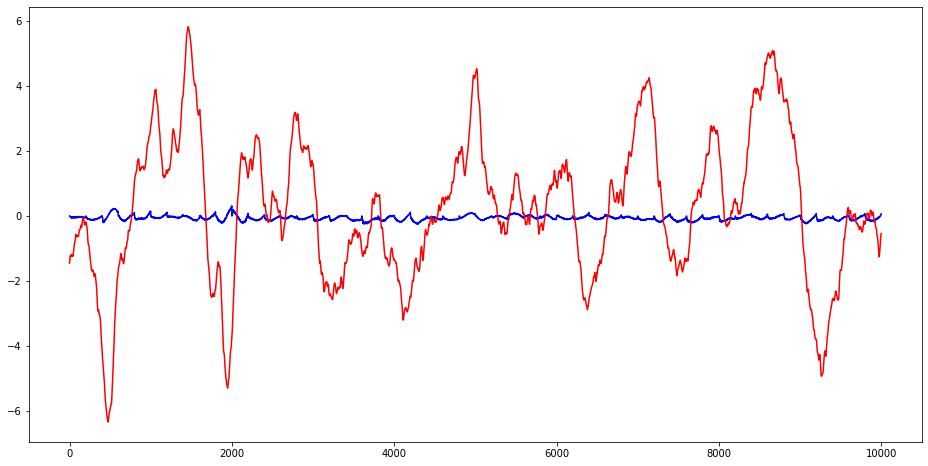

In [10]:
start = 10000
end = 20000
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot()
ax.plot(data_res[start:end,0], color="blue")
ax.plot(sound_res[start:end,0], color="red")
# self.writer.add_figure("Train/Plot", fig, data_res.size(0))
plt.show(fig)

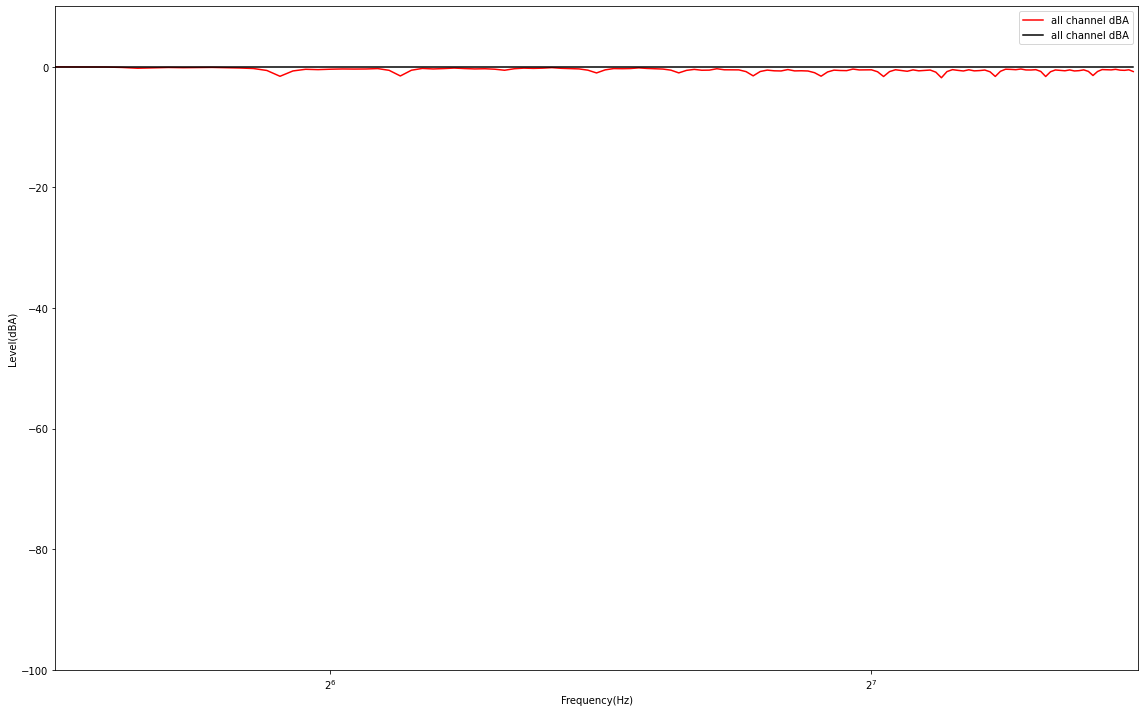

In [11]:
def sj_dBA_metric(y, gt, freq, plot=True):
    """
    |args|
    :y: generated sound data, it's shape should be (time, 8)
    :gt: ground truth data, it's shape should be (time, 8)
    :freq: frequency range(low, high) ex) (5, 20)
    :plot: if True, plot graph of each channels
    """
    assert len(freq) == 2
    d = gt
    e = gt - y
    Tn = y.shape[0]
    K = 8
    M = 8
    """Post processing : performance metric and plots"""
    p_ref = 20e-6
    fs = 2000
    Nfft = fs
    noverlap = Nfft / 2
    t = (np.arange(Tn) / fs)[np.newaxis, :]
    #win = hann(fs, False)
    win = windows.hamming(fs)
    #autopower calculation
    D = np.zeros((int(Nfft/2 + 1), M))
    E = np.zeros((int(Nfft/2 + 1), M))
    for m in range(M):
        F, D[:,m] = welch(d[:, m], fs=fs, window=win, noverlap=noverlap, nfft=Nfft, return_onesided=True, detrend=False)
        F, E[:,m] = welch(e[:, m], fs=fs, window=win, noverlap=noverlap, nfft=Nfft, return_onesided=True, detrend=False)
    
    A = filter_A(F)
    AA = np.concatenate([[A]] * M, axis=0).transpose(1,0)
    D_A = D * AA ** 2 / p_ref ** 2
    E_A = E * AA ** 2 / p_ref ** 2
    
    # perfomance metric calculation
    D_A_dBA_Sum = np.zeros((1,M))
    E_A_dBA_Sum = np.zeros((1,M))
    
    freq_range = np.arange(freq[0], freq[1])
    result = []
    E_result = []
    for m in range(M):
        D_A_dBA_Sum[0, m] = 10 * np.log10(np.sum(D_A[freq_range, m]))
        E_A_dBA_Sum[0, m] = 10 * np.log10(np.sum(E_A[freq_range, m]))
        result.append(D_A_dBA_Sum[0,m] - E_A_dBA_Sum[0,m])
        E_result.append(E_A_dBA_Sum[0, m])
    result.append(np.array(np.mean(result)))
    avg_result = np.mean(result)
    E_result = np.array(np.mean(E_result))
    E_re = np.mean(np.array(E_result))
    
    gs = gridspec.GridSpec(nrows= 1, # row 몇 개 
                       ncols=1, # col 몇 개 
                      )
    fig = plt.figure(figsize=(16,10))
    if plot:
        F =     F[freq_range]
        D_A = D_A[freq_range]
        E_A = E_A[freq_range]
        da = np.mean(D_A, -1, keepdims=False)
        ea = np.mean(E_A, -1, keepdims=False)

        plt.subplot(gs[0])
        plt.plot(F, 10 * np.log10(da / ea + 1e-16), color="red", label='all channel dBA')
        plt.plot(F, np.zeros_like(F), color="black", label='all channel dBA')

        plt.legend()
        plt.ylim((-100, 10))
        plt.xlim((freq[0],freq[1]))
        plt.xscale('log', base=2)
        plt.xlabel('Frequency(Hz)')
        plt.ylabel('Level(dBA)')
        plt.tight_layout()
        plt.show()
        # print(np.mean(10 * np.log10(da)) - np.mean(10 * np.log10(ea)))
        # 원래 score 구하는 건 각 채널별로 평균내서 뺀 것
        # 위 score는 채널 전체 평균낸것
    return avg_result, E_re
if config.filter:
    low, high = int(config.range.split('~')[0])//2, int(config.range.split('~')[0])*2
else:
    low = 1
    high = 500
score, _ = sj_dBA_metric(data_res[:], sound_res[:] ,(low, high),True)

In [12]:
score

-0.5924253680576879

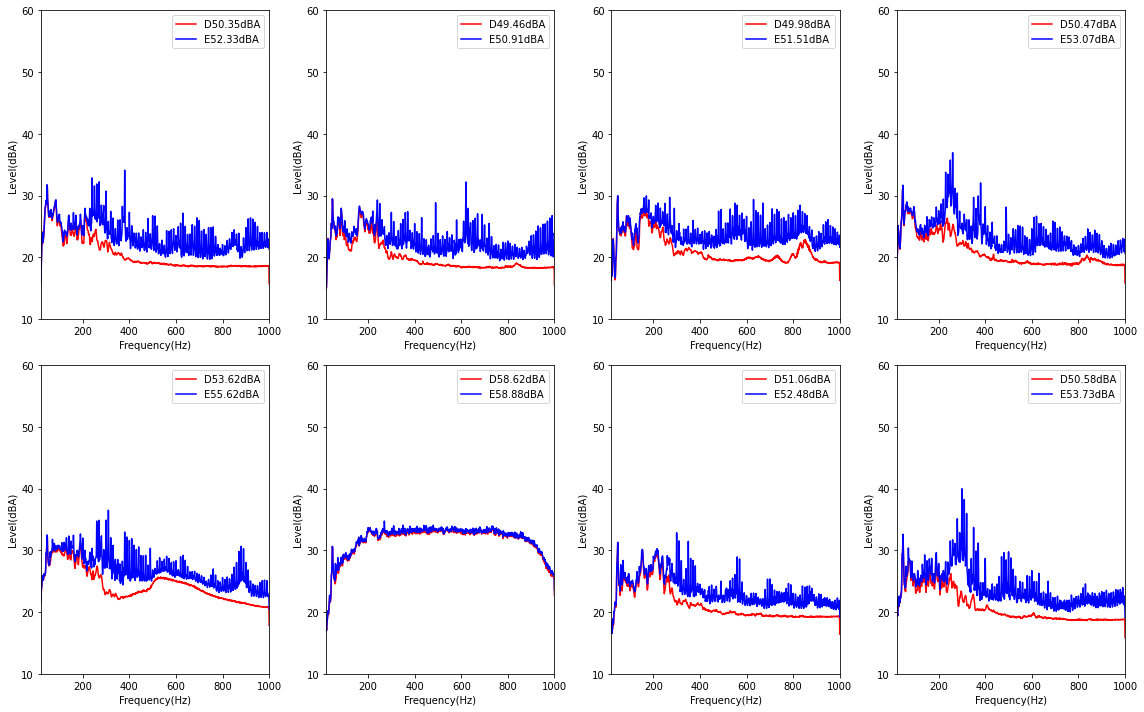

In [13]:
score, _ = dBA_metric(data_res[:], sound_res[:],True)

In [14]:
score

-1.8002860973567119

In [17]:
#da = {'y_p':data_res.cpu().numpy(), 'd':sound_res.cpu().numpy(), 's_filter': np.array(pickle.load(open(os.path.join(data_path,'transfer_f.pickle'),'rb')))}

In [19]:
#np.save('90~100data.npy', da)